<a href="https://colab.research.google.com/github/Yogi-20MIS7040/Face-Spoofing-Detection/blob/main/facespoofing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import os
import pathlib
import skimage.io as io
import skimage.transform as tf
import skimage.color as color
import torch

In [14]:
!pip install haroun
# import my Library (Pytorch Framework)
from haroun import Data, Model, ConvPool
from haroun.augmentation import augmentation
from haroun.losses import rmse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
def load_data():
  #In order to make the code work the path of the files should be specified (in this case the fake and the real photos have been uploaded in the content path of the google drive collab)
    path = pathlib.Path.cwd().parent / "/content"
    path = path / "real_and_fake_face"
    images = []
    labels = []


    for directory in os.listdir(path):
        data_path = path / directory
        
        for im in os.listdir(data_path)[:]:
            image = io.imread(f"{data_path}/{im}")
            image = tf.resize(image, (64, 64))
            images.append(image)
            if directory == "training_fake":
                labels.append("fake")
            elif directory == "training_real":
                labels.append("real")
    

    images = np.array(images)
    labels = np.array(labels)

    images, labels = augmentation(images, labels, flip_y=True, flip_x=True, brightness=True)

    return images, labels

In [16]:
classes = {'real': 0, 'fake': 1}
data = Data(loader=load_data(), classes=classes)
data.shape()

Data loaded successfully :)
Images shape: (11520, 64, 64, 3) Labels shape: (11520,)



In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data.dataset(split_size=0.05, shuffle=True, random_state=42,
             images_format=torch.float32, labels_format=torch.float32,
             permute=True, one_hot=True, device=device)

Train tensor shape: torch.Size([10944, 3, 64, 64]), torch.Size([10944, 2])
Test tensor shape: torch.Size([288, 3, 64, 64]), torch.Size([288, 2])
Validation tensor shape: torch.Size([288, 3, 64, 64]), torch.Size([288, 2])

Dataset generated successfully :)


In [18]:
class Network(torch.nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.input_norm = torch.nn.BatchNorm2d(3, affine=False)
        self.layer1 = ConvPool(in_features=3, out_features=8)
        self.layer2 = ConvPool(in_features=8, out_features=16)
        self.layer3 = ConvPool(in_features=16, out_features=32)
        self.layer4 = ConvPool(in_features=32, out_features=64)
        self.layer5 = ConvPool(in_features=64, out_features=128)
        self.layer6 = ConvPool(in_features=128, out_features=256)
        
        

        self.net = torch.nn.Sequential(self.layer1, self.layer2, self.layer3, 
                                       self.layer4, self.layer5, self.layer6)
            
        
        self.fc1 = torch.nn.Linear(in_features=256, out_features=128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        
        self.fc2 = torch.nn.Linear(in_features=128, out_features=32)
        self.bn2 = torch.nn.BatchNorm1d(32)

        self.fc3 = torch.nn.Linear(in_features=32, out_features=8)
        self.bn3 = torch.nn.BatchNorm1d(8)

        self.fc4 = torch.nn.Linear(in_features=8, out_features=2)


        self.lin = torch.nn.Sequential(self.fc1, self.bn1, self.fc2, self.bn2,
                                       self.fc3, self.bn3, self.fc4)  


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.input_norm(X)
        X = self.net(X)
        X = X.reshape(X.size(0), -1)
        X = self.lin(X)
        X = torch.nn.functional.elu(X, alpha=1.0, inplace=False)
        return X

In [19]:
net = Network()
# the epochs can be intcreased in order to make the model better 
AntiSpoofClassifier = Model(net, "adam", rmse, device)
AntiSpoofClassifier.train(train_data=(data.train_inputs, data.train_outputs),
                          val_data=(data.val_inputs, data.val_outputs),
                          epochs=100, patience=20, batch_size=100, learning_rate=1.0E-3)

Model initialized succssefully :)

Train loop:

	Epoch: 1/100,  Train Loss: 0.0873,  Val Loss: 0.0635
	Epoch: 2/100,  Train Loss: 0.0278,  Val Loss: 0.00346
	Epoch: 3/100,  Train Loss: 0.00139,  Val Loss: 0.00119
	Epoch: 4/100,  Train Loss: 0.000845,  Val Loss: 0.000804
	Epoch: 5/100,  Train Loss: 0.00071,  Val Loss: 0.000375
	Epoch: 6/100,  Train Loss: 0.000571,  Val Loss: 0.000683 - No improvement -> Remaining patience: 19
	Epoch: 7/100,  Train Loss: 0.000447,  Val Loss: 0.000418 - No improvement -> Remaining patience: 18
	Epoch: 8/100,  Train Loss: 0.000418,  Val Loss: 0.000257
	Epoch: 9/100,  Train Loss: 0.000347,  Val Loss: 0.000429 - No improvement -> Remaining patience: 19
	Epoch: 10/100,  Train Loss: 0.000337,  Val Loss: 0.000178
	Epoch: 11/100,  Train Loss: 0.000275,  Val Loss: 0.000296 - No improvement -> Remaining patience: 19
	Epoch: 12/100,  Train Loss: 0.000299,  Val Loss: 0.000146
	Epoch: 13/100,  Train Loss: 0.000305,  Val Loss: 0.000363 - No improvement -> Remaining pa

In [20]:
AntiSpoofClassifier.evaluate(test_data=(data.test_inputs, data.test_outputs))


Test accuracy:100%
Correct predictions: 288, Wrong predictions: 0


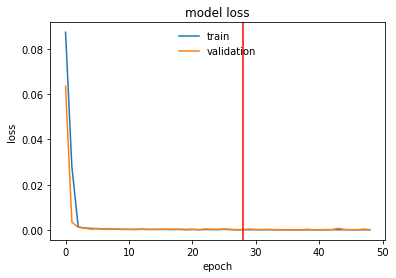


Checkpoint saved successfully :)


In [21]:
AntiSpoofClassifier.plot()
AntiSpoofClassifier.save(path="./", checkpoint_name="module")